## Synthetic Ensemble Generation

This notebook is used to test some capabilities of bm_methods with synthetic ensembles. This will prove useful for setting 'bimodal criteria' and understanding the expected TP/FP rates (as a function of ensemble size) with known distributions

In [1]:
# import packages

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns
from cython_routines import bm_methods as cbm
from scipy import integrate, stats, optimize
from sklearn.mixture import GaussianMixture


def scotts_factor(ens_size):
    """
    by default kde calculates bw using scotts factor:
    n** (-1/(d+4))
    when n = length of data and d is num of dimension (=1 for us)
    """
    return ens_size**(-1./(1+4))    
    

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# explore member FP(member requirement,delta) phase space

In [2]:
n = 10000 #number of ensembles to be generated
ens_size = 200 #ensemble size

deltas = np.arange(0., 5, 0.1) #separation of two modes
#mem_conditions = range(1,ens_size//2+1,2) #minimum number of members required
bms = np.zeros((len(deltas), n))
mem = np.zeros((len(deltas), n))

truth = np.zeros((len(deltas), 2))

for jj,d in enumerate(tqdm(deltas)):
    w=0.5
    m1=-d/2.; s1=1
    m2= d/2.; s2=1
    #generate the 'true dist', use GMM model
    true_dist = np.sort(np.append(np.random.normal(m1,s1,int(   w *1e6)),
                                  np.random.normal(m2,s2,int((1-w)*1e6)) ))

    ens = np.random.choice(true_dist, size = (n, ens_size), replace=True) #sample ens from true dist
    
    for qq,e in enumerate(ens): # detect number of bimodal ensemmbles using random sampling from true dist
        bm, mem1,_ = find_bimodality(e)
        bms[jj,qq] = bm
        mem[jj,qq] = mem1


100%|███████████████████████████████████████████| 50/50 [08:40<00:00, 10.40s/it]


In [3]:
mem_reqs = range(0, ens_size//2+1)

freqs = np.zeros((len(mem_reqs), len(deltas)))
for mm, mem_req in enumerate(mem_reqs):
    mask = ( mem_req <= mem) & (mem<= (ens_size-mem_req))
    
    # Set bms to False where mem < mem_req
    bms_filtered = np.copy(bms)
    bms_filtered[~mask] = False
    
    freqs[mm,:]= np.mean(bms_filtered, axis=-1)

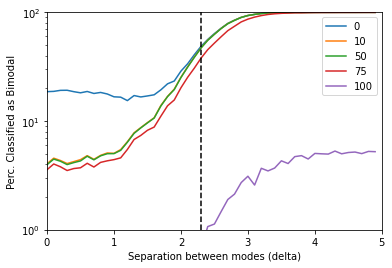

In [4]:
for m in [0,10,50,75,100]:
    plt.plot(deltas,freqs[m,:]*100, label = mem_reqs[m])
    
#for m in [0,2,5,20,25]:
#    plt.plot(deltas,freqs[m,:]*100, label = mem_reqs[m])
    
plt.yscale('log')
plt.legend()
plt.ylim(1e0,100)
plt.axvline(2.3, linestyle='--', color='k')
plt.xlim(0,5)
plt.xlabel('Separation between modes (delta)')
plt.ylabel('Perc. Classified as Bimodal')
plt.title('')
plt.show()